<a href="https://colab.research.google.com/github/AITrading1995/AITrading1995/blob/main/Copy_of_Simulation_backtest__data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git  pandas-ta backtesting  mplfinance sambo numpy==1.23.5

In [ ]:
import numpy as np
import pandas_ta as ta
import backtesting as bt
import numpy as np
import pandas as pd
import mplfinance as mpf
from backtesting import Backtest, Strategy
import matplotlib.pyplot as plt
from tvDatafeed import TvDatafeed, Interval
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


โหลด data จาก Trading view เปลี่ยน Font size ให้ ตรง กับ Library Backtesting

In [ ]:


def download(symbol, exchange, bar):
    """
    ฟังก์ชันดาวน์โหลดข้อมูลจาก TradingView ด้วย tvDatafeed

    Parameters:
        symbol (str): สัญลักษณ์ของสินทรัพย์ เช่น 'XAUUSD'
        exchange (str): ตลาด เช่น 'OANDA'
        bar (int): จำนวนแท่งข้อมูลย้อนหลัง

    Note:
        เปลี่ยน TimeFrame ได้ที่บรรทัด:
            interval = Interval.in_5_minute
        โดยเปลี่ยนเป็นค่าต่อไปนี้ตามต้องการ:
            - Interval.in_1_minute
            - Interval.in_5_minute
            - Interval.in_15_minute
            - Interval.in_30_minute
            - Interval.in_1_hour
            - Interval.in_4_hour
            - Interval.in_daily
    """

    tv = TvDatafeed()#ถ้ามี Account Tradingviwe ที่สมัคร แพ็กเกจ สามารถ login ได้ตรงนี้
    """username = 'YourTradingViewUsername'
       password = 'YourTradingViewPassword'

       tv = TvDatafeed(username, password)"""

    # เปลี่ยน TimeFrame ได้ตรงนี้
    interval = Interval.in_5_minute

    df = tv.get_hist(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        n_bars=bar
    )

    df.drop(columns='symbol', inplace=True)

    df.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    return df

In [ ]:
symbol = 'XAUUSD'      # สัญลักษณ์ของสินทรัพย์ = ทองคำ
exchange = 'OANDA'     # ตลาดที่ใช้ = OANDA
bar = 50000            # จำนวนแท่งข้อมูลย้อนหลัง = 50,000 แท่ง
# จำนวนแท่งย้อน หลัง กรณี สมัคร Account Trading view จะดึงได้ตามจำนวน แพคเกจที่สมัคร ถ้าไม่ได้สมัครไว้จะถึงได้สูงสุด 6000
df = download(symbol, exchange,bar)

In [ ]:
sim = df.copy() #copy data ไว้ สำหรับ simulator

In [ ]:


def simulate_gbm2(df, freq='5T', sigma_multiplier=2, n_steps=100000, save_path='simulated_gbm2.csv'):
    """
    สร้างชุดข้อมูลราคาจำลองด้วย Geometric Brownian Motion (GBM) โดยเพิ่มความผันผวน

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame ที่มีคอลัมน์ 'Close' ใช้สำหรับคำนวณ log return, mean (mu), std (sigma)
    freq : str
        ความถี่ของเวลา เช่น '1T' = 1 นาที, '5T' = 5 นาที (ค่าเริ่มต้น)
    sigma_multiplier : float
        คูณค่าความผันผวน เพื่อเพิ่มความรุนแรงของการเคลื่อนไหว (default = 2)
    n_steps : int
        จำนวนก้าวเวลา (จำนวนแท่งที่ต้องการจำลอง)
    save_path : str
        ชื่อไฟล์ที่ใช้บันทึกผลลัพธ์เป็น CSV

    Returns:
    --------
    sim_data : pd.DataFrame
        DataFrame ที่จำลองราคาด้วยโครงสร้าง OHLCV พร้อม index เป็น datetime
    """

    # Step 1: คำนวณ log return, mu, sigma
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    mu = df['log_return'].mean()
    sigma = df['log_return'].std()

    # Step 2: สร้าง GBM ด้วย volatility * multiplier
    S0 = df['Close'].iloc[-1]
    dt = 1
    sigma_adj = sigma * sigma_multiplier

    random_shocks = np.random.normal(0, 1, n_steps)
    W = np.cumsum(random_shocks) * np.sqrt(dt)
    t = np.arange(1, n_steps + 1)

    S = S0 * np.exp((mu - 0.5 * sigma_adj**2) * t + sigma_adj * W)

    # Step 3: สร้าง DataFrame OHLCV
    sim_df = pd.DataFrame({'Close': S})
    sim_df['Open'] = sim_df['Close'].shift(1).fillna(S0)
    sim_df['High'] = sim_df[['Open', 'Close']].max(axis=1) * (1 + 0.001)
    sim_df['Low'] = sim_df[['Open', 'Close']].min(axis=1) * (1 - 0.001)
    sim_df['Volume'] = np.random.randint(100, 1000, size=n_steps)

    start = pd.Timestamp.now().floor(freq)
    sim_df.index = pd.date_range(start=start, periods=n_steps, freq=freq)
    sim_df.index.name = 'datetime'

    # Step 4: บันทึกและโหลด CSV เพื่อความมั่นใจ
    sim_df.to_csv(save_path)
    sim_data = pd.read_csv(save_path)
    sim_data.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    sim_data.set_index('datetime', inplace=True)

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        sim_data[col] = pd.to_numeric(sim_data[col], errors='coerce')
    sim_data.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)
    sim_data.index = pd.to_datetime(sim_data.index)

    return sim_data

In [ ]:


def plot_real_vs_sim(df, sim_data, symbol):
    """
    แสดงกราฟราคาจริงและราคาจำลองเพื่อเช็คสภาวะตลาด

    Parameters:
    -----------
    df : pd.DataFrame
        ข้อมูลราคาจริง (มีคอลัมน์ 'Close')
    sim_data : pd.DataFrame
        ข้อมูลราคาจำลอง (มีคอลัมน์ 'Close')
    symbol : str
        ชื่อสินทรัพย์ เช่น 'XAUUSD'
    """
    plt.figure(figsize=(14,6))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,6))

    ax1.plot(df.Close, color='blue')
    ax1.set_title(f'Real data {symbol}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')

    ax2.plot(sim_data.Close, color='orange')
    ax2.set_title(f'Simulation {symbol}')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')

    plt.suptitle(f'Comparison of Real vs Simulation Price for {symbol}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:

sim_data = simulate_gbm2(sim)             # สร้างข้อมูลจำลอง GBM ที่มี volatility * 2

<Figure size 1400x600 with 0 Axes>

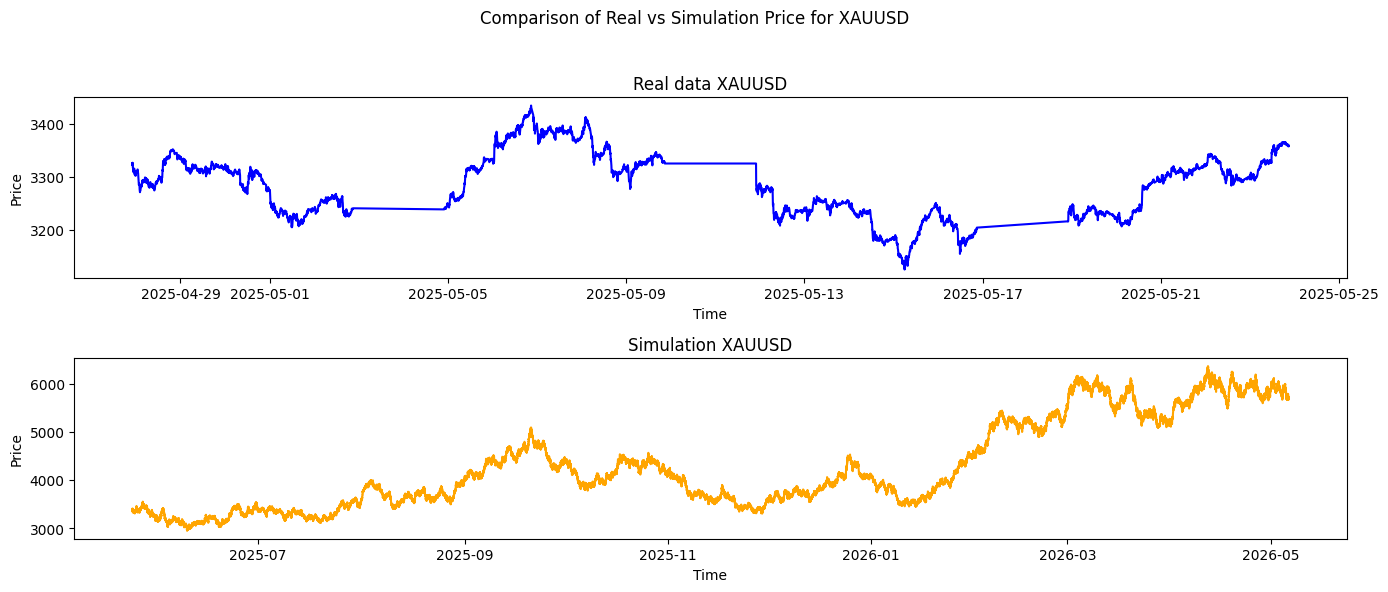

In [ ]:
plot_real_vs_sim(df, sim_data, symbol)

<Figure size 3000x1400 with 0 Axes>

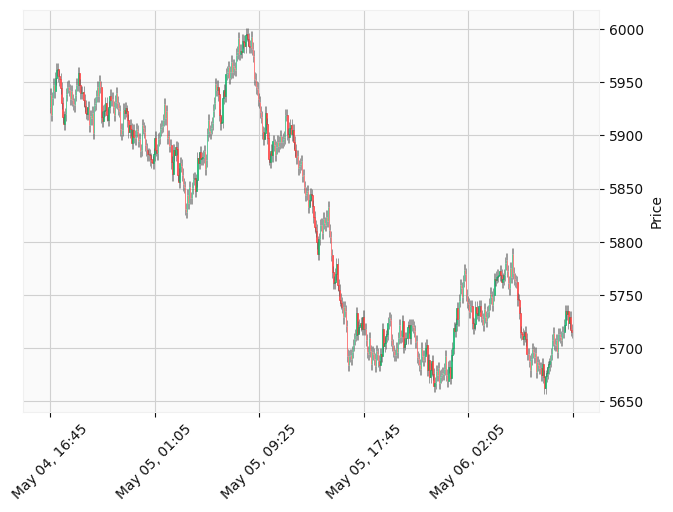

In [ ]:


# กำหนดขนาดของรูปกราฟใหญ่ขึ้น เพื่อให้ดูรายละเอียดแท่งเทียนได้ชัดเจน
plt.figure(figsize=(30, 14))

# ใช้ mplfinance.plot() เพื่อวาดกราฟแท่งเทียน (candlestick chart)
# sim_data.iloc[-500:] เลือกข้อมูล 500 แถวล่าสุด
# type='candle' คือชนิดของกราฟ (แท่งเทียน)
# style='yahoo' คือรูปแบบสีสไตล์ของกราฟ (สามารถเปลี่ยนเป็น 'binance', 'charles', 'nightclouds' ได้)
mpf.plot(
    sim_data.iloc[-500:],   # ข้อมูลแท่งเทียน (ล่าสุด 500 แท่ง)
    type='candle',           # ประเภทกราฟ: candlestick
    style='yahoo'            # รูปแบบสี: yahoo
)

# แสดงกราฟบนหน้าจอ
plt.show()

เตรียม Indicator

In [ ]:
def ema(series, value):
    # ตรวจสอบว่า input ที่ส่งเข้ามาเป็น pandas Series หรือไม่
    # ถ้าไม่ใช่ ให้แปลงเป็น Series เพื่อให้ pandas_ta ทำงานได้
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    # คำนวณค่า Exponential Moving Average (EMA) โดยใช้ pandas_ta
    # length=value หมายถึงจำนวนแท่งเวลาที่ใช้คำนวณ เช่น 10, 20, 50 เป็นต้น
    ema_result = ta.ema(series, length=value)

    # ตรวจสอบว่าได้ผลลัพธ์กลับมาหรือไม่ ถ้าไม่ได้แสดงว่าเกิดข้อผิดพลาด
    if ema_result is None:
        raise ValueError(f"EMA calculation failed for length={value}")

    # แปลงผลลัพธ์ที่ได้จาก pandas Series เป็น NumPy array
    # เพื่อใช้งานกับระบบ Backtesting ที่อาจต้องการ array เพื่อประมวลผลเร็วขึ้น
    return ema_result.to_numpy()

In [ ]:
def rsi(df, value):
    # แปลงข้อมูลที่รับเข้ามาให้เป็น pandas Series (กรณีรับเข้ามาเป็น list หรือ numpy array)
    df = pd.Series(df)

    # คำนวณค่า RSI (Relative Strength Index) โดยใช้ pandas_ta
    # value คือช่วงเวลาสำหรับคำนวณ RSI เช่น 14 (RSI 14 วัน)
    rsi = ta.rsi(df, value)

    # คืนค่าเป็น numpy array เพื่อให้ใช้งานร่วมกับระบบ backtest ได้เร็วขึ้น
    return rsi.to_numpy()

Class สำหรับ ทดสอบ กลยุทธ์ ที่ใช้ Data Simulator

In [ ]:
class Rsi(Strategy):
    # ตั้งค่าพารามิเตอร์ของกลยุทธ์
    n_rsi = 50       # จำนวน period สำหรับ RSI
    n_ema = 50       # จำนวน period สำหรับ EMA
    sl_pct = 0.005   # Stop-loss ที่ 0.5%
    tp_pct = 0.008   # Take-profit ที่ 0.8%

    def init(self):
        # สร้างตัวชี้วัด RSI และ EMA จากข้อมูลราคาปิด
        self.rsi = self.I(rsi, self.data.Close, self.n_rsi)
        self.ema = self.I(ema, self.data.Close, self.n_ema)
        self.close = self.data.Close  # เก็บข้อมูลราคาปิดล่าสุดไว้ใช้งานสะดวก

    def next(self):
        # ดึงราคาปิดล่าสุด
        price = self.close[-1]

        # คำนวณ Stop Loss และ Take Profit เป็นจำนวนเงิน
        sl_amount = price * self.sl_pct
        tp_amount = price * self.tp_pct

        # ปรับ TP ให้น้อยลงครึ่งหนึ่งถ้า RSI เข้าสู่โซน overbought (RSI > 70)
        if self.rsi[-2] >= 70:
            tp_amount *= 0.5

        # เงื่อนไขซื้อ: ราคาปิดสูงกว่า EMA และ RSI สูงกว่า 50 (เป็นแนวโน้มขาขึ้น)
        buy_condition = price > self.ema[-2] and self.rsi[-2] > 50

        # เงื่อนไขขาย: ราคาปิดต่ำกว่า EMA และ RSI ต่ำกว่า 50 (เป็นแนวโน้มขาลง)
        sell_condition = price < self.ema[-2] and self.rsi[-2] < 50

        # ถ้ายังไม่มีสถานะ (ยังไม่ได้ถือ Long หรือ Short)
        if not self.position:

            if buy_condition:
                # เข้าซื้อด้วยราคาปัจจุบัน กำหนด SL/TP
                self.buy(limit =price,sl=price - sl_amount, tp=price + tp_amount)

            elif sell_condition:
                # เข้าขายด้วยราคาปัจจุบัน กำหนด SL/TP
                self.sell(limit=price, sl=price + sl_amount, tp=price - tp_amount)

ผลลัพธ์ การทดสอบ กลยุทธ์ กับ Data จำลอง โดย ที่ สภาวะ ตลาด ผันผวน ขึ้น จากเดิม 2 เท่า

In [ ]:
# เรียกใช้งาน backtest ด้วยข้อมูลจำลองจาก Monte Carlo (sim_data) และกลยุทธ์ Rsi
bt = Backtest(
    sim_data,          # ใช้ข้อมูลจำลองที่ได้จากการสร้างด้วย GBM (Geometric Brownian Motion)
    Rsi,               # คลาสกลยุทธ์ RSI+EMA ที่เราเขียนไว้
    cash=10_000,       # เงินเริ่มต้นในพอร์ต
    commission=0.000002 # ค่าคอมมิชชั่นต่อคำสั่ง (0.0002%)
)

# สั่งให้ระบบทำ backtest และแสดงผลลัพธ์
print(bt.run())

Backtest.run:   0%|          | 0/99949 [00:00<?, ?bar/s]

Start                     2025-05-24 05:05:00
End                       2026-05-06 10:20:00
Duration                    347 days 05:15:00
Exposure Time [%]                      52.888
Equity Final [$]                  15670.38588
Equity Peak [$]                     15707.639
Commissions [$]                    1134.64576
Return [%]                           56.70386
Buy & Hold Return [%]                70.87457
Return (Ann.) [%]                    60.49787
Volatility (Ann.) [%]                38.34864
CAGR [%]                             60.35032
Sharpe Ratio                          1.57758
Sortino Ratio                         4.55405
Calmar Ratio                          5.92061
Alpha [%]                            44.24128
Beta                                  0.17584
Max. Drawdown [%]                   -10.21818
Avg. Drawdown [%]                    -0.36255
Max. Drawdown Duration      109 days 19:30:00
Avg. Drawdown Duration        0 days 18:18:00
# Trades                          

In [ ]:
bt.plot()

GridPlot(id='p1389', ...)

In [ ]:
# สร้างอ็อบเจกต์ Backtest โดยใช้ข้อมูลจำลอง sim_data และกลยุทธ์ Rsi
bt = Backtest(
    sim_data,           # ข้อมูลราคาจำลอง (DataFrame ที่มีคอลัมน์ OHLCV และ DatetimeIndex)
    Rsi,                # คลาสกลยุทธ์ที่เราสร้างไว้ (RSI+EMA)
    cash=10_000,        # เงินทุนเริ่มต้น 10,000 หน่วย
    commission=0.000002

# ทำการ Optimize เพื่อหาค่าพารามิเตอร์ที่ดีที่สุดของกลยุทธ์
stats, heatmap = bt.optimize(
    n_rsi=range(10, 100, 10),       # ทดสอบค่า RSI period ตั้งแต่ 10 ถึง 90 (เพิ่มทีละ 10)
    n_ema=range(10, 100, 10),       # ทดสอบค่า EMA period ตั้งแต่ 10 ถึง 90
    sl_pct=[0.003, 0.004, 0.005],   # ค่าระดับ stop-loss 0.3%, 0.4%, 0.5%
    tp_pct=[0.008, 0.010, 0.012],   # ค่าระดับ take-profit 0.8%, 1.0%, 1.2%
    constraint=lambda p: p.sl_pct < p.tp_pct and p.n_rsi <= p.n_ema,
    # เงื่อนไข: stop-loss ต้องน้อยกว่า take-profit และ RSI period ต้องไม่มากกว่า EMA period
    maximize='Equity Final [$]',     # หาค่าพารามิเตอร์ที่ให้มูลค่าพอร์ตสูงสุดเมื่อจบการทดสอบ
    max_tries=100,                  # ทดสอบค่าพารามิเตอร์แบบสุ่มสูงสุด 100 ครั้ง สามารถปรับเปลี่ยน ได้ กรณี การ์ดจอ แรง
    random_state=42,                # ตั้งค่า seed สำหรับผลลัพธ์ที่ reproducible
    return_heatmap=True             # คืนค่า heatmap สำหรับวิเคราะห์ผลการ Optimize
)

Backtest.optimize:   0%|          | 0/102 [00:00<?, ?it/s]

Backtest.run:   0%|          | 0/99950 [00:00<?, ?bar/s]

In [ ]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p3040', ...)

In [ ]:
heatmap.sort_values().iloc[-5:]

n_rsi  n_ema  sl_pct  tp_pct
20     90     0.004   0.012     16165.569824
       80     0.004   0.010     16180.964878
       50     0.005   0.008     16266.818710
       20     0.004   0.008     16327.240526
       50     0.004   0.008     16383.488273
Name: Equity Final [$], dtype: float64

เอา param ที่ optimize แล้ว ของ Data ที่ มีความผันผวน ขึ้นจากเดิม 2 เท่า ไป ทดสอบ กับ Data ที่ โหลดมา

In [ ]:
class Rsi(Strategy):
    # ตั้งค่าพารามิเตอร์ของกลยุทธ์
    n_rsi = 20 # จำนวน period สำหรับ RSI สำหรับ ค่าที่ได้ จาก optimize
    n_ema = 20 # จำนวน period สำหรับ EMA สำหรับ ค่าที่ได้ จาก optimize
    sl_pct = 0.005 # Stop-loss ที่ 0.10%
    tp_pct = 0.008 # Take-profit ที่ 0.12%

    def init(self):
        # สร้างตัวชี้วัด RSI และ EMA จากข้อมูลราคาปิด
        self.rsi = self.I(rsi, self.data.Close, self.n_rsi)
        self.ema = self.I(ema, self.data.Close, self.n_ema)
        self.close = self.data.Close  # เก็บข้อมูลราคาปิดล่าสุดไว้ใช้งานสะดวก

    def next(self):
        # ดึงราคาปิดล่าสุด
        price = self.close[-1]

        # คำนวณ Stop Loss และ Take Profit เป็นจำนวนเงิน
        sl_amount = price * self.sl_pct
        tp_amount = price * self.tp_pct

        # ปรับ TP ให้น้อยลงครึ่งหนึ่งถ้า RSI เข้าสู่โซน overbought (RSI > 70)
        if self.rsi[-2] >= 70:
            tp_amount *= 0.5

        # เงื่อนไขซื้อ: ราคาปิดสูงกว่า EMA และ RSI สูงกว่า 50 (เป็นแนวโน้มขาขึ้น)
        buy_condition = price > self.ema[-2] and self.rsi[-2] > 50

        # เงื่อนไขขาย: ราคาปิดต่ำกว่า EMA และ RSI ต่ำกว่า 50 (เป็นแนวโน้มขาลง)
        sell_condition = price < self.ema[-2] and self.rsi[-2] < 50

        # ถ้ายังไม่มีสถานะ (ยังไม่ได้ถือ Long หรือ Short)
        if not self.position:

            if buy_condition:
                # เข้าซื้อด้วยราคาปัจจุบัน กำหนด SL/TP
                self.buy(limit =price,sl=price - sl_amount, tp=price + tp_amount)

            elif sell_condition:
                # เข้าขายด้วยราคาปัจจุบัน กำหนด SL/TP
                self.sell(limit=price, sl=price + sl_amount, tp=price - tp_amount)

In [ ]:
# เรียกใช้งาน backtest ด้วยข้อมูลที่ดึงมาจากตลาด และกลยุทธ์ Rsi ที่ปรับ ค่า แล้ว
bt = Backtest(
    df,          # ใช้ข้อมูลจริง
    Rsi,               # คลาสกลยุทธ์ RSI+EMA ที่เราเขียนไว้
    cash=10_000,       # เงินเริ่มต้นในพอร์ต
    commission=0.000002
)

# สั่งให้ระบบทำ backtest และแสดงผลลัพธ์
print(bt.run())

Backtest.run:   0%|          | 0/5499 [00:00<?, ?bar/s]

Start                     2025-04-27 22:00:00
End                       2025-05-23 20:55:00
Duration                     25 days 22:55:00
Exposure Time [%]                    55.09058
Equity Final [$]                  10279.84073
Equity Peak [$]                   10302.91073
Commissions [$]                       54.4376
Return [%]                            2.79841
Buy & Hold Return [%]                 1.56946
Return (Ann.) [%]                    33.61557
Volatility (Ann.) [%]                11.10753
CAGR [%]                             30.73076
Sharpe Ratio                          3.02638
Sortino Ratio                          6.5787
Calmar Ratio                         14.95651
Alpha [%]                              2.5193
Beta                                  0.17784
Max. Drawdown [%]                    -2.24755
Avg. Drawdown [%]                    -0.23757
Max. Drawdown Duration       12 days 16:20:00
Avg. Drawdown Duration        0 days 20:34:00
# Trades                          

In [ ]:
bt.plot()

GridPlot(id='p3442', ...)

ใช้ข้อมูลจำลองเพื่อป้องกัน Overfitting

จุดประสงค์:
สร้างสภาพตลาด "สุดโต่ง" เช่น ผันผวนสูงหรือเทรนด์รุนแรง เพื่อดูว่ากลยุทธ์ยัง "เอาตัวรอด" ได้ไหม
หากระบบรอดจากข้อมูลที่ ไม่เหมือนข้อมูลจริง ก็มีแนวโน้มว่า จะไม่ Overfit กับข้อมูลในอดีต

ข้อควรระวัง:
ข้อมูลจำลองไม่ควรใช้เพื่อฝึกโมเดลหรือวัดผลโดยตรง
แต่ควรใช้เพื่อ “ทดสอบความทนทาน” ของระบบเท่านั้น